In [137]:
from sklearn.model_selection import train_test_split
import os
import glob
import cv2
import tensorflow as tf
import numpy as np
from keras import backend
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util import montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
data_dir = './dataset'
train_image_dir = os.path.join(data_dir, 'train')
test_image_dir = os.path.join(data_dir, 'test')
import gc; gc.enable() # memory is tight
from skimage.morphology import label


In [138]:
BATCH_SIZE = 8
EDGE_CROP = 2
NB_EPOCHS = 40
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'DECONV'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3

In [139]:
def get_all_imgs():
    img_path = os.path.join(train_image_dir,'images')
#     mask_path = os.path.join(train_image_dir,'masks')
    images = glob.glob(os.path.join(img_path,'*.*'))
#     masks = glob.glob(os.path.join(mask_path,'*.*'))
    return [image.split('/')[-1] for image in images]

In [140]:
print(get_all_imgs())
TRAIN_IMGS, TEST_IMGS = train_test_split(get_all_imgs())

['260.jpeg', '246.png', '245.jpeg', '128.jpeg', '66.jpeg', '185.jpeg', '34.jpeg', '263.None', '23.jpeg', '148.jpeg', '147.png', '85.jpeg', '50.jpeg', '77.jpeg', '167.jpeg', '177.jpeg', '134.jpeg', '221.jpeg', '250.jpeg', '11.jpeg', '102.jpeg', '233.jpeg', '3.jpeg', '189.jpeg', '266.jpeg', '56.jpeg', '182.jpeg', '24.jpeg', '131.jpeg', '170.jpeg', '152.jpeg', '133.jpeg', '16.png', '19.jpeg', '160.jpeg', '219.jpeg', '253.jpeg', '9.jpeg', '72.jpeg', '188.jpeg', '78.jpeg', '71.jpeg', '45.jpeg', '57.jpeg', '179.jpeg', '118.None', '146.jpeg', '26.jpeg', '104.jpeg', '91.jpeg', '176.jpeg', '226.jpeg', '184.jpeg', '2.jpeg', '255.jpeg', '135.jpeg', '186.jpeg', '107.jpeg', '193.jpeg', '5.jpeg', '196.jpeg', '126.jpeg', '103.jpeg', '108.jpeg', '230.jpeg', '40.jpeg', '268.jpeg', '244.jpeg', '15.jpeg', '127.jpeg', '243.jpeg', '191.jpeg', '8.jpeg', '229.jpeg', '153.jpeg', '280.jpeg', '141.jpeg', '21.jpeg', '38.jpeg', '106.jpeg', '209.jpeg', '97.jpeg', '33.jpeg', '232.jpeg', '69.jpeg', '53.jpeg', '139.j

In [141]:
import random
def cv2_brightness_augment(img):
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    v = hsv[:,:,2]
    seed = random.uniform(0.5,1.2)
    v = (( v/255.0 ) * seed)*255.0
    hsv[:,:,2] = np.array(np.clip(v,0,255),dtype=np.uint8)
    rgb_final = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    return rgb_final
    

In [151]:
def get_mask_filename(img_id, masks_list):
    for m in masks_list:
        if img_id.split('.')[0] in m:
            return m
    return -1

In [152]:
def make_image_gen(img_file_list=TRAIN_IMGS, batch_size = BATCH_SIZE):
    all_batches = TRAIN_IMGS
    out_rgb = []
    out_mask = []
    img_path = os.path.join(train_image_dir,'images')
    mask_path = os.path.join(train_image_dir,'masks')
    print(img_path)
    masks_list = os.listdir(mask_path)
    
    while True:
        np.random.shuffle(all_batches)
        for c_img_id in all_batches:
            c_img = imread(os.path.join(img_path,c_img_id))
            #Apply Brightness augmentation
            c_img = cv2_brightness_augment(c_img)
#             c_mask = imread(os.path.join(mask_path,c_img_id))
            if get_mask_filename(c_img_id, masks_list) == -1: continue
            c_mask = imread(os.path.join(mask_path, get_mask_filename(c_img_id, masks_list)))
            if IMG_SCALING is not None:
                c_img = cv2.resize(c_img,(256,256),interpolation = cv2.INTER_AREA)
                c_mask = cv2.resize(c_mask,(256,256),interpolation = cv2.INTER_AREA)
            c_mask = np.reshape(c_mask,(c_mask.shape[0],c_mask.shape[1],-1))
            c_mask = c_mask > 0
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

## Make Training Set

In [153]:
train_gen = make_image_gen()
train_x, train_y = next(train_gen)

print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

./dataset/train/images
x (8, 256, 256, 3) 0.0 1.0
y (8, 256, 256, 3) False True


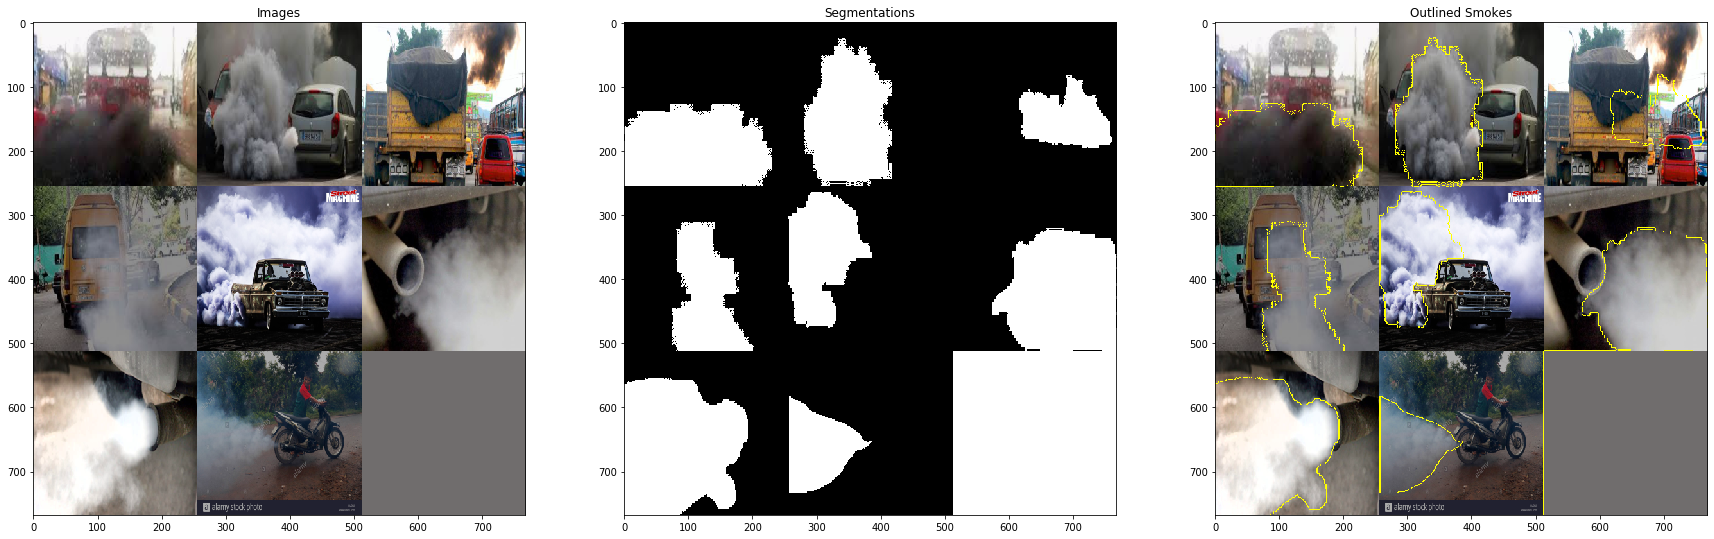

In [158]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg,cmap='gray')
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Smokes')
fig.savefig('overview.png')

## Make Validation Set

In [159]:
valid_x, valid_y = next(make_image_gen(TEST_IMGS,len(TEST_IMGS)))
print(valid_x.shape, valid_y.shape)

./dataset/train/images
(70, 256, 256, 3) (70, 256, 256, 3)


## Augment Data

In [160]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 15, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = False,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')

image_gen = ImageDataGenerator(**dg_args)

label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

In [166]:

cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray')
ax2.set_title('smoke')

StopIteration: 

In [167]:
gc.collect()

7492

## Build a Model
### Here we use Linknet <https://www.kaggle.com/kmader/keras-linknet>

In [168]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, concatenate, AvgPool2D, Lambda, Dropout
from keras.layers import Deconvolution2D as Deconv2D

network_mode = 'bn'
s_c2 = lambda fc, k, s = 1, activation='elu', **kwargs: Conv2D(fc, kernel_size = (k,k), strides= (s,s),
                                       padding = 'same', activation = activation,
                                       **kwargs)
s_d2 = lambda fc, k, s = 1, activation='elu', **kwargs: Deconv2D(fc, kernel_size=(k,k), strides=(s,s), 
                                                       padding = 'same', activation=activation,
                                                       **kwargs)
if network_mode == 'bn':
    from keras.layers import BatchNormalization, Activation
    c2 = lambda fc, k, s = 1, **kwargs: lambda x: Activation('elu')(BatchNormalization()(
        Conv2D(fc, kernel_size = (k,k), strides= (s,s),
               padding = 'same', activation = 'linear', **kwargs)(x)))

    d2 = lambda fc, k, s = 1, **kwargs: lambda x: Activation('elu')(BatchNormalization()(
        Deconv2D(fc, kernel_size=(k,k), strides=(s,s), 
                 padding = 'same', activation='linear', **kwargs)(x)))
else:
    c2 = s_c2
    d2 = s_d2

In [169]:
# Build U-Net model
start_in = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name = 'Input')
start_scale = Lambda(lambda x: x / 255) (start_in)
# pre-processing
in_filt = c2(64, 7, 2)(start_scale)
in_mp = MaxPool2D((3,3), strides = (2,2), padding = 'same')(in_filt)

In [170]:
from keras import backend as K
from keras.regularizers import l2
from keras.layers import add

def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[1] / residual_shape[1]))
    stride_height = int(round(input_shape[2] / residual_shape[2]))
    equal_channels = input_shape[3] == residual_shape[3]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[3],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])

def enc_block(m, n):
    def block_func(x):
        cx = c2(n, 3)(c2(n, 3, 2)(x))
        cs1 = concatenate([AvgPool2D((2,2))(x), 
                           cx])
        cs2 = c2(n, 3)(c2(n, 3)(cs1))
        return concatenate([cs2, cs1])
    return block_func
def dec_block(m, n):
    def block_func(x):
        cx1 = c2(m//4, 1)(x)
        cx2 = d2(m//4, 3, 2)(cx1)
        return Dropout(0.1)(c2(n, 1)(cx2))
    return block_func

In [171]:
enc1 = enc_block(64, 64)(in_mp)
enc2 = enc_block(64, 128)(enc1)
enc3 = enc_block(128, 256)(enc2)
enc4 = enc_block(256, 512)(enc3)

dec4 = dec_block(256, 512)(enc4)
dec4_cat = _shortcut(enc3, dec4)

dec3 = dec_block(128, 256)(dec4_cat)
dec3_cat = _shortcut(enc2, dec3)

dec2 = dec_block(64, 128)(dec3_cat)
dec2_cat = _shortcut(enc1, dec2)

dec1 = dec_block(64, 64)(dec2_cat)

last_out = _shortcut(dec1, in_mp)

In [172]:
# post-processing
out_upconv = d2(32, 3, 2)(last_out)
out_conv = c2(32, 3)(out_upconv)
out = s_d2(1, 2, 2, activation = 'sigmoid')(out_conv)

In [173]:
seg_model = Model(inputs = [start_in], outputs = [out]) 
seg_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 3)  0           Input[0][0]                      
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 128, 128, 64) 9472        lambda_2[0][0]                   
__________________________________________________________________________________________________
batch_normalization_32 (BatchNo (None, 128, 128, 64) 256         conv2d_30[0][0]                  
____________________________________________________________________________________________

In [174]:
from keras import backend as K
from keras.metrics import binary_crossentropy
smooth = 1.

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def bce_dice(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred)-K.log(dice_coef(y_true, y_pred))

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

seg_model.compile(optimizer = 'adam', 
              loss = bce_dice, 
              metrics = ['binary_accuracy', dice_coef, true_positive_rate])

In [175]:
# Fit model
from  keras.callbacks  import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('linknet_model')
step_count = min(MAX_TRAIN_STEPS, len(TRAIN_IMGS)//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen())
val_gen = make_image_gen(TEST_IMGS, len(TEST_IMGS)//BATCH_SIZE)
earlyStopper = EarlyStopping(monitor="val_dice_coef", mode="max", patience=15)
checkPointer = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)
#reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', patience=4, cooldown=0) 
#    model.fit(X_train, Y_train, callbacks=[reduce_lr])
reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=4, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
loss_history = [seg_model.fit_generator(aug_gen,
                            steps_per_epoch=step_count, 
                            epochs=NB_EPOCHS, 
                            validation_data=val_gen,
                            validation_steps=len(TEST_IMGS)//BATCH_SIZE, 
                            callbacks=[earlyStopper, reduceLROnPlat, checkPointer],
                            workers=1)]


/home/angry/anaconda3/envs/ml/lib/python3.6/site-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


./dataset/train/images
./dataset/train/images
Epoch 1/40


InvalidArgumentError: Incompatible shapes: [1572864] vs. [524288]
	 [[{{node metrics_1/true_positive_rate/mul}}]]

In [176]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')
    
    _ = ax2.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('DICE')

show_loss(loss_history)

NameError: name 'loss_history' is not defined

In [183]:
# seg_model.load_weights(weight_path)
# seg_model.save('linknet_model.h5')
k 
k.save('linknet_model.h5')

NameError: name 'k' is not defined

In [25]:
#seg_model.load_weights(weight_path)
#seg_model.load_weights('linknet_model.h5')

In [ ]:
# from keras.models import load_model

In [184]:
pred_y = seg_model.predict(valid_x)
print(pred_y.shape, pred_y.min(), pred_y.max(), pred_y.mean())

(70, 256, 256, 1) 0.0063773394 0.9849422 0.21795803


In [185]:
import matplotlib.pyplot as plt
from random import randint

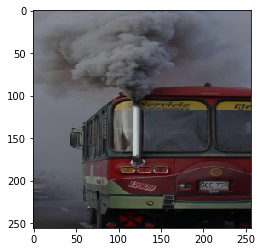

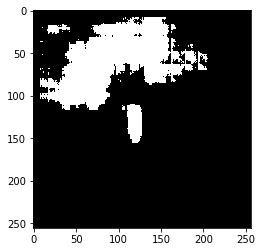

In [225]:
# valid_x.shape
idx = randint(0, len(pred_y))

img = np.ceil(valid_x[idx]*255).astype(np.uint8)
plt.imshow(img)
plt.imshow(valid_x[idx])
plt.show()

plt.imshow(pred_y[idx][:, :, 0] > (pred_y.max() + pred_y.min())/2, cmap='gray')
plt.show()

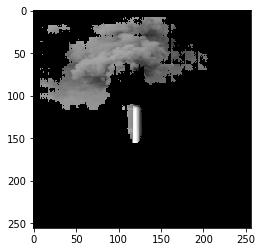

Porcentaje: 60.33%


In [260]:
pred_mat = pred_y[idx][:, :, 0] > (pred_y.max() + pred_y.min())/2
res: np.ndarray = np.stack((pred_mat, pred_mat, pred_mat))
res = res.transpose((1, 2, 0))

res = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) * pred_mat

plt.imshow(res, cmap='gray')
plt.show()
c = 0
p = 0
for row in res:
    for col in row:
        if col != 0:
            c += 1
            p += col
            
# print(p)
# print(c)
var = ((p / c) * 100) / 255
print('Porcentaje: {0:.2f}%'.format(100-var))
# print(p/c)
        

(1, 256, 256, 1)


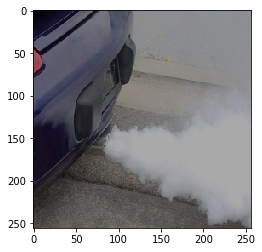

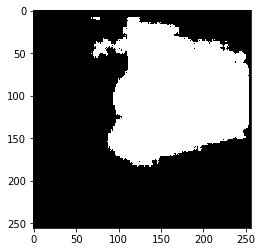

In [248]:
t_img = imread('humo1.jpg')
#Apply Brightness augmentation
t_img = cv2_brightness_augment(t_img)
t_img = cv2.resize(t_img, (256,256), interpolation = cv2.INTER_AREA)/255.0
t_img = np.expand_dims(t_img, 0)

t_pred = seg_model.predict(t_img)
print(t_pred.shape)

t_img_r = np.ceil(t_img*255).astype(np.uint8)

plt.imshow(t_img_r[0])
plt.show()

plt.imshow(t_pred[0, :, :, 0] > (t_pred.max() + t_pred.min())/2, cmap='gray')
plt.show()

## Prepare Full Resolution Model

In [95]:
    # if IMG_SCALING is not None:
#     fullres_model = models.Sequential()
#     fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
#     fullres_model.add(seg_model)
#     fullres_model.add(layers.UpSampling2D(IMG_SCALING))
# else:
#     fullres_model = seg_model
# fullres_model.save('fullres_model.h5')

## Run the test data

In [96]:
# test_paths = os.listdir(test_image_dir)
# print(len(test_paths), 'test images found')

FileNotFoundError: [Errno 2] No such file or directory: './dataset/test'

NameError: name 'test_paths' is not defined

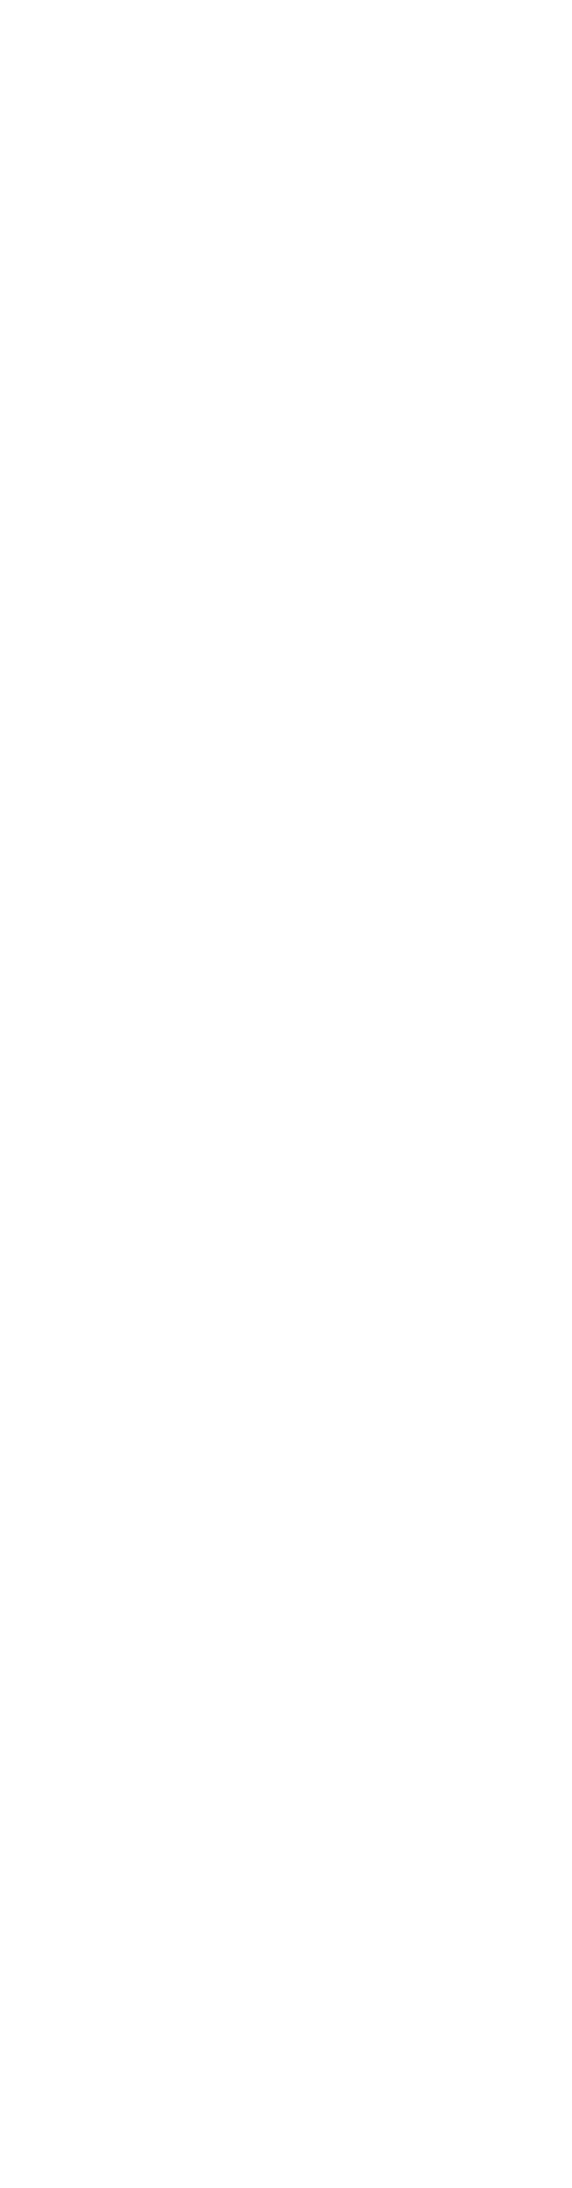

In [97]:
# from sklearn.preprocessing import normalize
# fig, m_axs = plt.subplots(20, 2, figsize = (10, 40))
# [c_ax.axis('off') for c_ax in m_axs.flatten()]
# for (ax1, ax2), c_img_name in zip(m_axs, test_paths):
#     c_path = os.path.join(test_image_dir, c_img_name)
#     c_img = imread(c_path)
#     c_img = cv2.resize(c_img,(256,256))
#     first_img = np.expand_dims(c_img, 0)/255.0
#     first_seg = seg_model.predict(first_img)
#     first_img[0][:,:,0] = (first_img[0][:,:,0]*0.7 + 0.5*first_seg[0, :, :, 0])
#     result = np.array(np.clip(first_img[0]*255.,0,255),dtype=np.int32)
#     ax1.imshow(result)
#     ax1.set_title('Image')
#     ax2.imshow(first_seg[0, :, :, 0], vmin = 0, vmax = 1, cmap='gray')
#     ax2.set_title('Prediction')
# fig.savefig('test_predictions.png')

In [98]:
# from moviepy.editor import VideoFileClip
# def process_image(image):
#     # NOTE: The output you return should be a color image (3 channel) for processing video below
#     # TODO: put your pipeline here,
#     # you should return the final output (image where lines are drawn on lanes)
#     image_shape = image.shape[:2]
# #     print(image_shape)
#     image = cv2.resize(image,(256,256))
#     first_img = np.expand_dims(image, 0)/255.0
# #     result = image_pipeline(image)
#     first_seg = seg_model.predict(first_img)
#     first_img[0][:,:,0] = first_img[0][:,:,0]*0.7 + 0.3*first_seg[0, :, :, 0]
#     result = np.array(np.clip(first_img[0]*255,0,255),dtype=np.float)
# #     print(image_shape[:2],result.shape,type(result[0][0][0]))
#     result = cv2.resize(result,image_shape[::-1])
# #     result = result[...,::-1]
    
#     return result

In [99]:
# # filename='videoplayback_2.mp4'
# filename='videoplayback.mp4'
# clip = VideoFileClip(filename)
# white_clip = clip.fl_image(process_image)
# %time white_clip.write_videofile(filename.split('.')[0]+'_detection_centro.mp4', audio=False)

t:   1%|          | 4/747 [00:00<00:22, 33.23it/s, now=None]

Moviepy - Building video videoplayback_detection_centro.mp4.
Moviepy - Writing video videoplayback_detection_centro.mp4



Moviepy - Done !
Moviepy - video ready videoplayback_detection_centro.mp4
CPU times: user 2min 16s, sys: 3.22 s, total: 2min 20s
Wall time: 27.8 s


In [230]:
# def get_video(src):
#     def pred_gen(src):
#         ret = True
#         while ret:
#             ret, image = cv2.videoCapture(src)
#             image = cv2.resize(image,(256,256))
#             yield image
#     return pred_gen
# def make_video():
#     fourcc = cv2.VideoWriter_fourcc(*'MP4V')
#     out = cv2.VideoWriter('videoplayback_out.mp4',fourcc, 25.0, (360,640))
#     video_gen = get_video('videoplayback.mp4')
#     resultant_clips = seg_model.predict_generator(video_gen)
#     print('Prediction complete')
#     for frame in resultant_clips:
#         out.write(frame)
#     out.release()
#     print('Video written')
# make_video()

ValueError: `steps=None` is only valid for a generator based on the `keras.utils.Sequence` class. Please specify `steps` or use the `keras.utils.Sequence` class.